**<center><span style="font-family:serif; font-size:34px;"> Decoding Student Retention and Churn of Vodafone (Telecel) in KNUST - A Survival Analytics Approach </span>
<a id = "missingvalue" ></a><center>**

<center><span style="font-family:Palatino; font-size:22px;"><i>A comparative analysis between Cox Proportional Hazards<span style="color:#DC143C;"> and</span> Accelerated Failure Time </i> </center>

***

## Install Missing Packages

In [10]:
# pip install seaborn
# pip install lifelines
# pip install plotly
# pip install pandas
# pip install LabelEncoder
# pip install numpy
# pip install ydata_profiling


## Load Packages

In [11]:
import pandas as pd
# data = pd.read_csv('encoded_values_2.csv')
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from lifelines import CoxPHFitter, KaplanMeierFitter
import numpy as np
from ydata_profiling import ProfileReport
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px #for histogram
sns.set(style="whitegrid")

## Import Dataset

In [12]:
data = pd.read_csv('Churn Data.csv')
data.head()

,Gender,Churn,Residence,Usage_Freq,Voice_Calls,Mobile_Data_Internet,SMS_Text_Messaging,Data_Exhaustion,Multiple_Networks,Poor_Network_Quality_Coverage,Unsatisfactory_Customer_Service,High_Costs_Pricing,Monthly_Data_Usage,Churn_Level
0,Female,No,Off-campus,Daily,Yes,Yes,No,Yes,Yes,No,Yes,Yes,8 and more,4
1,Female,No,Off-campus,Several times a week,Yes,No,No,Yes,Yes,No,Yes,Yes,6-8,4
2,Female,Yes,On-campus,Never,Yes,Yes,No,Yes,Yes,No,No,No,8 and more,3
3,Female,No,Off-campus,Occasionally,Yes,Yes,Yes,No,Yes,No,Yes,Yes,6-8,4
4,Male,No,Off-campus,Several times a week,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,8 and more,4


In [13]:
data.describe(include=["object", "bool"]) # For non-numeric


,Gender,Churn,Residence,Usage_Freq,Voice_Calls,Mobile_Data_Internet,SMS_Text_Messaging,Data_Exhaustion,Multiple_Networks,Poor_Network_Quality_Coverage,Unsatisfactory_Customer_Service,High_Costs_Pricing,Monthly_Data_Usage
count,338,338,338,338,338,338,338,338,338,338,338,338,338
unique,2,2,2,5,2,2,2,2,2,2,2,2,5
top,Female,No,Off-campus,Daily,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,8 and more
freq,233,259,279,170,285,302,180,283,312,276,288,291,231


## Descriptive Analysis of Churn Data

In [14]:
import plotly.express as px

color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(data, x="Churn", color_discrete_map=color_map)
fig.update_layout(
    width=700, 
    height=500, 
    bargap=0.1,
    yaxis_title='Number of students'  # Set the y-axis label
)
fig.show()


In [15]:
# Uncomment for a more detailed data analysis 
# ProfileReport(data, title="Profiling Report") 

## Data Preprocesisng

In [16]:
# Check for missing values
missing_values = data.isnull().sum()

# Check data types
data_types = data.dtypes

missing_values
    

Gender                             0
Churn                              0
Residence                          0
Usage_Freq                         0
Voice_Calls                        0
Mobile_Data_Internet               0
SMS_Text_Messaging                 0
Data_Exhaustion                    0
Multiple_Networks                  0
Poor_Network_Quality_Coverage      0
Unsatisfactory_Customer_Service    0
High_Costs_Pricing                 0
Monthly_Data_Usage                 0
Churn_Level                        0
dtype: int64

In [17]:
# Create a DataFrame to store the encoded values
encoded_values = pd.DataFrame(columns=['Feature', 'Category', 'Encoded Value'])
# Get all the categorical columns
category_feature = data.select_dtypes(include=['object']).columns

# Create a LabelEncoder object
le = LabelEncoder()

# Iterate through each categorical feature
for feature in category_feature:
    # Fit the LabelEncoder on the current feature and transform the data
    data[feature] = le.fit_transform(data[feature])

    # Get the encoded values for the current feature
    for category, encoded_value in zip(le.classes_, le.transform(le.classes_)):
        # Create a temporary DataFrame to hold the current row
        temp_df = pd.DataFrame([{'Feature': feature, 'Category': category, 'Encoded Value': encoded_value}])

        # Append the temporary DataFrame to the main DataFrame
        encoded_values = pd.concat([encoded_values, temp_df], ignore_index=True)


## Kaplan Meier Analysis

The Kaplan-Meier estimator calculates the survival probability at a specific time step by multiplying the probability of surviving each previous time step.

Let $S(t)$ be the survival probability at time $t$. The estimator is computed as:

$$
S(t) = \prod_{t_i \leq t} \left(1 - \frac{d_i}{n_i}\right)
$$

where:
- 
- $t_i$ is the time of the $i$-th unique event (churn)
- $d_i$ is the number of events (churn) at time $i$
- $n_i$ is the number of students at risk just prior to time $i$

The estimator essentially calculates the probability of surviving from one time step to the next, and the product of these probabilities gives the overall survival probability up to time $t$.


Here, $t_1$ would be the time at which the first churn event occurred, $d_1$ would be 1 (since one churn event occurred), and $n_1$ would be the total number of students at that time.


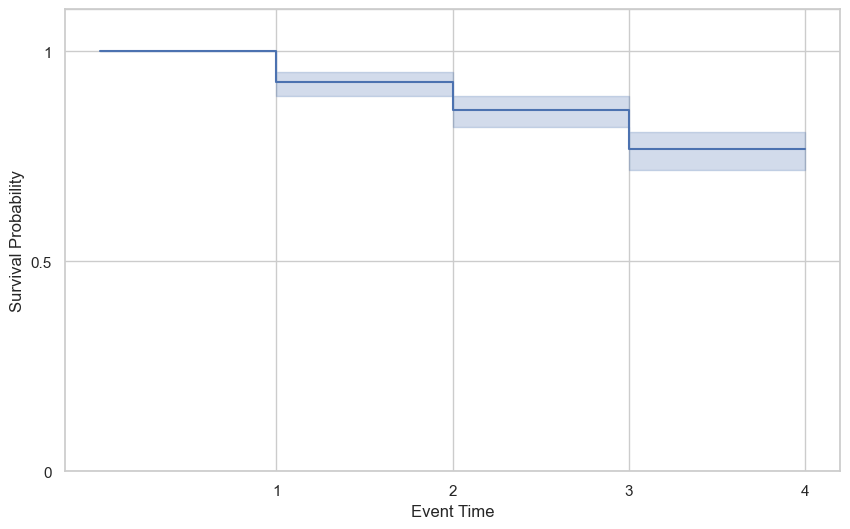

,Event Time,Number of Individuals,Number of Events,Survival Probability,Lower CI,Upper CI
0,0.0,338,0,1.000000,1.000000,1.000000
1,1.0,338,25,0.926036,0.892497,0.949406
2,2.0,313,22,0.860947,0.819283,0.893630
3,3.0,291,32,0.766272,0.717405,0.807836
4,4.0,259,0,0.766272,0.717405,0.807836


In [18]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Assuming 'data' is your dataset with columns 'Churn_Level' and 'Churn'

# Fit Kaplan-Meier estimator
kmf = KaplanMeierFitter()
kmf.fit(data['Churn_Level'], data['Churn'])

# Initial number of censored individuals
initial_censored = 338

# Calculate number of censored individuals (did not churn) at each event time
n_individuals = len(data)
censored_counts = [initial_censored]

for i in range(1, len(kmf.timeline)):
    churned_count = kmf.event_table.iloc[i-1]['observed']  # Number of events (churns) at current event time
    censored_count = censored_counts[i-1] - churned_count
    censored_counts.append(censored_count)

# Extract event counts (number of churns) at each event time
event_counts = kmf.event_table['observed'].values

# Extract survival probabilities
survival_probs = kmf.survival_function_.iloc[:, 0].values

# Confidence intervals from Kaplan-Meier estimator
confidence_intervals = kmf.confidence_interval_survival_function_

# Create a DataFrame to display the information
table_data = {
    'Event Time': kmf.timeline,
    'Number of Individuals': censored_counts,
    'Number of Events': event_counts,
    'Survival Probability': survival_probs,
    'Lower CI': confidence_intervals['KM_estimate_lower_0.95'].values,
    'Upper CI': confidence_intervals['KM_estimate_upper_0.95'].values
}

df = pd.DataFrame(table_data)

# Plotting the survival curves using Kaplan-Meier Estimator
plt.figure(figsize=(10, 6))
ax = kmf.plot_survival_function()
ax.get_legend().remove()  # Remove the legend

# Set custom y-axis ticks and labels
plt.yticks([0, 0.5, 1, 1.1], ['0', '0.5', '1', ''])
plt.xticks([1, 2, 3, 4, 4.2], ['1', '2', '3', '4', ''])

plt.xlabel('Event Time')
plt.ylabel('Survival Probability')
plt.show()

# Print the DataFrame
df


## Cox Proportional Hazard (Cox PH)
The Cox Proportional Hazards model is a popular semi-parametric model for survival analysis. It models the relationship between the survival time and a set of predictor variables, assuming a proportional hazard rate.

**Mathematical Computation:**

The Cox PH model is represented as:

$$
h(t \mid x) = h_0(t) \exp(\beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p)
$$

where:
- $h(t \mid x)$ is the hazard function, i.e., the instantaneous rate of the event occurring at time $t$ given the predictor variables $x$
- $h_0(t)$ is the baseline hazard function, representing the hazard for individuals with all predictor variables equal to zero
- $\beta_1, \beta_2, ..., \beta_p$ are the coefficients for the predictor variables

The coefficients are estimated using maximum likelihood estimation, and the model assumes a proportional hazard ratio, meaning the effect of the predictors on the hazard is constant over time.


In [19]:
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
# Initialize the Cox Proportional Hazards model
cph = CoxPHFitter()
# data = data.drop(columns=['High_Costs_Pricing','Multiple_Networks','Other_Networks_Better_Services','Poor_Network_Quality_Coverage'])
# data = data.drop(columns='Poor_Network_Quality_Coverage')

# Fit the model
cph.fit(data, duration_col='Churn_Level', event_col='Churn')

# Display the summary
cph.print_summary()




<lifelines.CoxPHFitter: fitted with 338 total observations, 259 right-censored observations>
             duration col = 'Churn_Level'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 338
number of events observed = 79
   partial log-likelihood = -316.76
         time fit was run = 2024-08-29 00:43:26 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                        
Gender                           0.33      1.39      0.28           -0.23            0.89                0.80                2.42
Residence                        0.32      1.38      0.27           -0.22            0.86                0.80                2.36
Usage_Freq                      -0.08      0.92      0.07           -0.23            0.06                0.80                1.06
Voice_Calls                     -0.57      0.57      0.32           -1.19            0.06                0.30                1.06
Mobile_Data_Internet             0.32      1.38      0.46           -0.57            1.21                0.56                3.36
SMS_Text_Messaging               0.48      1.61      0.25           -0.01            0.96                0.99                2.61
Data_Exhaustion                 -0.20      0.82      0.38           -0.94            0.55                0.39                1.73
Multiple_Networks               -0.13      0.88      0.44           -0.99            0.74                0.37                2.10
Poor_Network_Quality_Coverage    2.60     13.49      0.35            1.91            3.29                6.75               26.98
Unsatisfactory_Customer_Service -1.40      0.25      0.30           -2.00           -0.81                0.14                0.44
High_Costs_Pricing              -1.13      0.32      0.29           -1.70           -0.56                0.18                0.57
Monthly_Data_Usage               0.21      1.24      0.09            0.03            0.40                1.03                1.49

                                 cmp to     z      p  -log2(p)
covariate                                                     
Gender                             0.00  1.16   0.24      2.03
Residence                          0.00  1.16   0.25      2.02
Usage_Freq                         0.00 -1.11   0.27      1.90
Voice_Calls                        0.00 -1.77   0.08      3.71
Mobile_Data_Internet               0.00  0.70   0.48      1.06
SMS_Text_Messaging                 0.00  1.92   0.06      4.18
Data_Exhaustion                    0.00 -0.52   0.61      0.72
Multiple_Networks                  0.00 -0.28   0.78      0.36
Poor_Network_Quality_Coverage      0.00  7.36 <0.005     42.30
Unsatisfactory_Customer_Service    0.00 -4.65 <0.005     18.22
High_Costs_Pricing                 0.00 -3.91 <0.005     13.43
Monthly_Data_Usage                 0.00  2.27   0.02      5.45
---
Concordance = 0.96
Partial AIC = 657.52
log-likelihood ratio test = 266.68 on 12 df
-log2(p) of ll-ratio test = 163.93

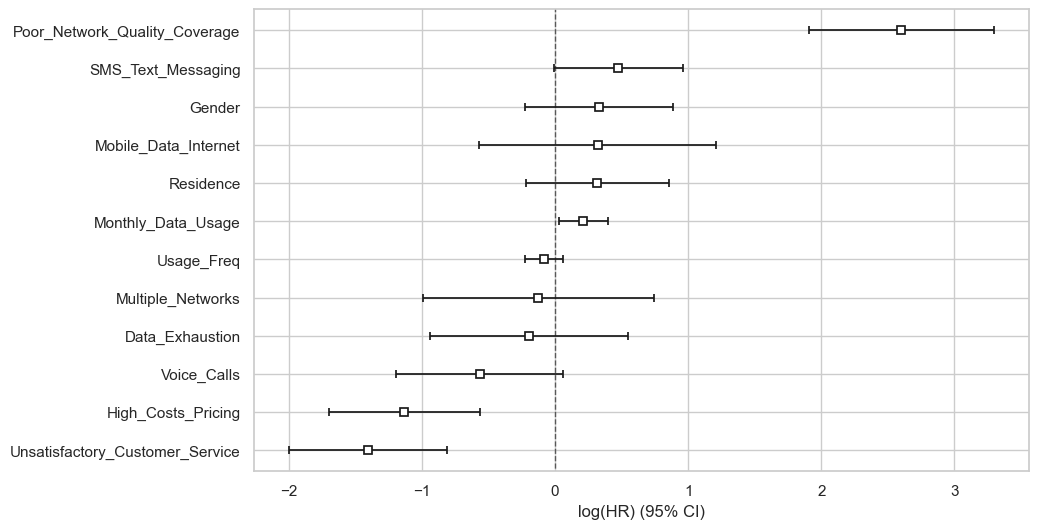

In [20]:
# Plot the coefficients
plt.figure(figsize=(10, 6))
cph.plot()
# plt.title('Cox Proportional Hazards Model Coefficients')
plt.show()

## Cox PH Assumption Test
The Cox PH makes an assumption that, time is constant throughout.
$$ H_0: \text{The Assumption of Proportional Hazard is fulfilled} $$
$$ H_1: \text{The Assumption of Proportional Hazard is not fulfilled} $$

In [21]:
from lifelines.statistics import proportional_hazard_test

# Fit the Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(data, duration_col='Churn_Level', event_col='Churn')

# Perform the proportional hazards test
results = proportional_hazard_test(cph, data, time_transform='rank')

# # Print the results
# cph.plot_partial_effects_on_outcome('Other_Networks_Better_Services', values=[0, 1, 2, 3, 4])
# plt.title('Partial Effects of Other Networks Better Services on Survival')
# plt.show()
results# Plot the scaled Schoenfeld residuals


# Interpretation and validation
# (This will involve checking the summary output, coefficients, and assumption checks)


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 338 total observations, 259 right-censored observations>
         test_name = proportional_hazard_test

---
                                 test_statistic    p  -log2(p)
Data_Exhaustion                            0.46 0.50      1.00
Gender                                     0.26 0.61      0.71
High_Costs_Pricing                         1.74 0.19      2.42
Mobile_Data_Internet                       0.63 0.43      1.22
Monthly_Data_Usage                         1.49 0.22      2.17
Multiple_Networks                          0.09 0.77      0.38
Poor_Network_Quality_Coverage              2.36 0.12      3.00
Residence                                  0.01 0.93      0.10
SMS_Text_Messaging                         0.04 0.84      0.25
Unsatisfactory_Customer_Service            0.10 0.76      0.40
Usage_Freq                                 0.04 0.84      0.25
Voice_Calls                                2.70 0.10      3.32

## Accelerated Failure Time
Accelerated Failure Time (AFT) is one of the popular parametric models used in survival analysis. The model assumes that the survival function \(S(t)\) follows a parametric continuous distribution. This implies that the distribution is following a Weibull, lognormal, or log-logistic distribution. An AFT model aims to account for the influence of multiple covariates on the survival time by either accelerating or decelerating it.

$$\lambda(x) = \exp(b_0 + \sum_{i=1}^{n}{b_i x_i})$$
Where:
   - $\lambda(x)$ is the accelerating factor
   - $b_0$ is the baseline accelerating factor when all covariates are 0
   - $b_i$ is the regression coefficient for the $i$ th covariate
   - $x_i$ are the covariates


In [22]:
import pandas as pd
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter
import numpy as np


# Instantiate each AFT fitter
weibull_aft = WeibullAFTFitter()
lognormal_aft = LogNormalAFTFitter()
loglogistic_aft = LogLogisticAFTFitter()

# Fit to data and collect AIC, BIC, and Hanna-Quinn values
aft_metrics = {}
for model in [weibull_aft, lognormal_aft, loglogistic_aft]:
    model.fit(data, duration_col='Churn_Level', event_col='Churn')
    aic = model.AIC_
    bic = model.BIC_  # You can get BIC directly from lifelines
    n = len(data)
    k = len(model.params_)

    # Hanna-Quinn criterion calculation
    hqc = np.log(n) * k * np.log(np.log(n)) + 2 * k * np.log(n)

    aft_metrics[model.__class__.__name__] = {
        'AIC': aic,
        'BIC': bic,
        'Hanna-Quinn': hqc
    }

# Create a DataFrame from the metrics
metrics_df = pd.DataFrame(aft_metrics).T
metrics_df.index.name = 'Model'
metrics_df = metrics_df.reset_index()

print("Model Comparison Metrics:")
print(metrics_df)

# Find the model with the lowest AIC, BIC, and Hanna-Quinn
best_aft_model_aic = metrics_df.loc[metrics_df['AIC'].idxmin(), 'Model']
best_aft_model_bic = metrics_df.loc[metrics_df['BIC'].idxmin(), 'Model']
best_aft_model_hqc = metrics_df.loc[metrics_df['Hanna-Quinn'].idxmin(), 'Model']

print(f"\nThe AFT model with the lowest AIC is: {best_aft_model_aic}")
print(f"The AFT model with the lowest BIC is: {best_aft_model_bic}")
print(f"The AFT model with the lowest Hanna-Quinn is: {best_aft_model_hqc}")


Model Comparison Metrics:
                  Model         AIC         BIC  Hanna-Quinn
0      WeibullAFTFitter  316.433303  300.079395    306.67379
1    LogNormalAFTFitter  305.805320  289.451411    306.67379
2  LogLogisticAFTFitter  307.510343  291.156435    306.67379

The AFT model with the lowest AIC is: LogNormalAFTFitter
The AFT model with the lowest BIC is: LogNormalAFTFitter
The AFT model with the lowest Hanna-Quinn is: WeibullAFTFitter


In [23]:
from lifelines import LogNormalAFTFitter
weibull_aft = LogNormalAFTFitter()
weibull_aft.fit(data, duration_col='Churn_Level', event_col='Churn')
weibull_aft.print_summary(3)

<lifelines.LogNormalAFTFitter: fitted with 338 total observations, 259 right-censored observations>
             duration col = 'Churn_Level'
                event col = 'Churn'
   number of observations = 338
number of events observed = 79
           log-likelihood = -138.903
         time fit was run = 2024-08-29 00:43:27 UTC

---
                                         coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                                         
mu_    Data_Exhaustion                  0.102     1.107     0.148          -0.189           0.392               0.828               1.480
       Gender                           0.032     1.033     0.118          -0.199           0.263               0.820               1.301
       High_Costs_Pricing               0.515     1.674     0.122           0.276           0.754               1.318               2.127
       Mobile_Data_Internet            -0.287     0.750     0.207          -0.693           0.118               0.500               1.125
       Monthly_Data_Usage              -0.069     0.933     0.044          -0.155           0.016               0.857               1.016
       Multiple_Networks               -0.104     0.901     0.202          -0.499           0.292               0.607               1.339
       Poor_Network_Quality_Coverage   -1.041     0.353     0.123          -1.283          -0.799               0.277               0.450
       Residence                       -0.146     0.864     0.124          -0.389           0.097               0.678               1.102
       SMS_Text_Messaging              -0.228     0.796     0.108          -0.440          -0.015               0.644               0.985
       Unsatisfactory_Customer_Service  0.809     2.246     0.122           0.569           1.049               1.767               2.855
       Usage_Freq                      -0.002     0.998     0.033          -0.066           0.061               0.936               1.063
       Voice_Calls                      0.132     1.141     0.135          -0.133           0.397               0.875               1.488
       Intercept                        1.626     5.084     0.393           0.857           2.395               2.356              10.972
sigma_ Intercept                       -0.616     0.540     0.084          -0.780          -0.451               0.458               0.637

                                        cmp to      z       p  -log2(p)
param  covariate                                                       
mu_    Data_Exhaustion                   0.000  0.686   0.493     1.021
       Gender                            0.000  0.273   0.785     0.350
       High_Costs_Pricing                0.000  4.226 <0.0005    15.359
       Mobile_Data_Internet              0.000 -1.390   0.165     2.602
       Monthly_Data_Usage                0.000 -1.585   0.113     3.145
       Multiple_Networks                 0.000 -0.514   0.607     0.720
       Poor_Network_Quality_Coverage     0.000 -8.433 <0.0005    54.726
       Residence                         0.000 -1.177   0.239     2.065
       SMS_Text_Messaging                0.000 -2.101   0.036     4.811
       Unsatisfactory_Customer_Service   0.000  6.615 <0.0005    34.646
       Usage_Freq                        0.000 -0.075   0.940     0.089
       Voice_Calls                       0.000  0.977   0.329     1.605
       Intercept                         0.000  4.143 <0.0005    14.831
sigma_ Intercept                         0.000 -7.333 <0.0005    42.018
---
Concordance = 0.958
AIC = 305.805
log-likelihood ratio test = 290.678 on 12 df
-log2(p) of ll-ratio test = 180.620

<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

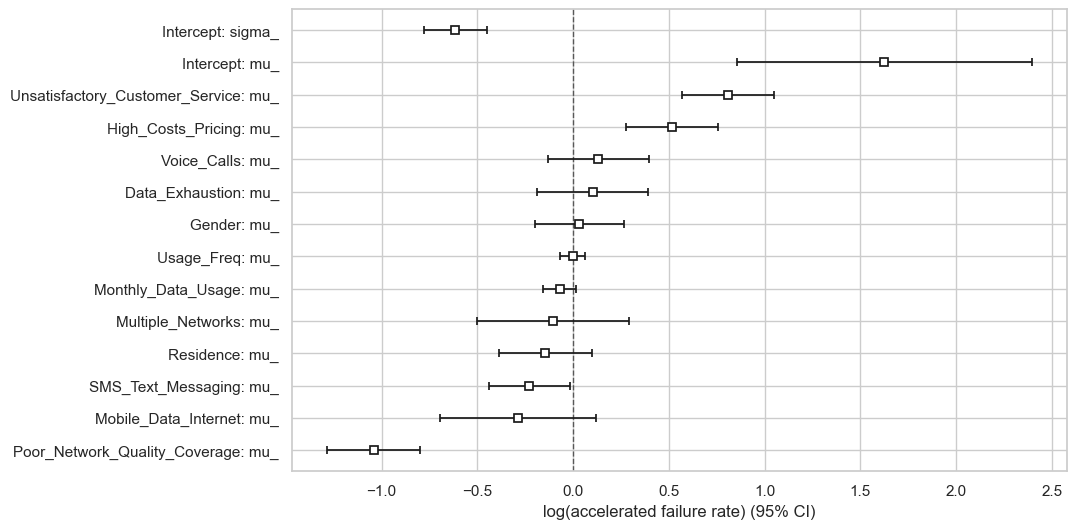

In [24]:
plt.subplots(figsize=(10, 6))
weibull_aft.plot()
